## Task B: Multi-class Classification

In [ ]:
! pip install medmnist

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO,PathMNIST
from medmnist.evaluator import Evaluator

In [4]:
data_flag = 'pathmnist'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print("Task: {},\nn_channels: {},\nn_classes: {}".format(task,n_channels,n_classes))

Task: multi-class,
n_channels: 3,
n_classes: 9


#### 1. Data Analysis and Visualization

In [5]:
def view_data(split):
    l = []
    data = PathMNIST(split=split, root='/content/drive/MyDrive/Datasets/')
    print("-----------------------{}-----------------------".format(split))
    print(data)
    label = pd.DataFrame(data.labels,columns=['label'])
    count = label.value_counts()
    for i in range(9):
        l.append(count[i])
    return l

In [6]:
l_train,l_val,l_test = view_data('train'), view_data('val'), view_data('test')

-----------------------train-----------------------
Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /content/drive/MyDrive/Datasets/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source i

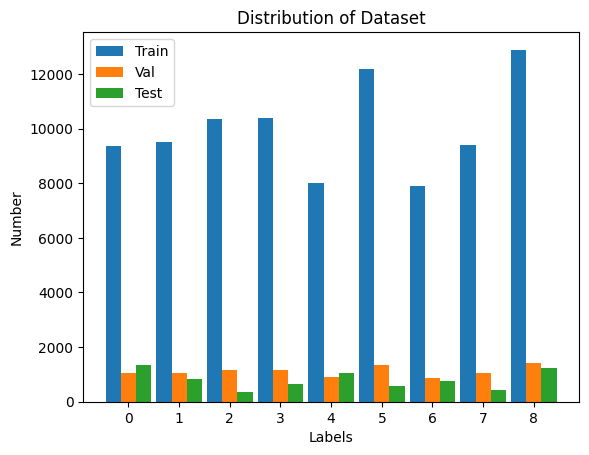

In [7]:
import matplotlib.pyplot as plt
bar_width = 0.3
index_train = np.arange(9)
index_val,index_test = index_train+bar_width,index_train+2*bar_width
plt.bar(index_train,l_train,width=bar_width,label='Train')
plt.bar(index_val,l_val,width=bar_width,label='Val')
plt.bar(index_test,l_test,width=bar_width,label='Test')
plt.title("Distribution of Dataset")
plt.legend()
plt.xticks(index_val, range(9))
plt.xlabel('Labels')
plt.ylabel('Number')
plt.show()

In [8]:
l_train

[9366, 9509, 10360, 10401, 8006, 12182, 7886, 9401, 12885]

#### 2. Preprocessing and Augmentation

In [39]:
data_transform = transforms.Compose([
    #transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-20,20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [40]:
train_dataset = PathMNIST(split='train', transform=data_transform, root='/content/drive/MyDrive/Datasets/')
val_dataset = PathMNIST(split='val', transform=data_transform, root='/content/drive/MyDrive/Datasets/')
test_dataset = PathMNIST(split='test', transform=data_transform, root='/content/drive/MyDrive/Datasets/')

In [41]:
train_dataset[0][0].shape

torch.Size([3, 28, 28])

In [49]:
train_dataset.montage(length=1)

#### 3. Model Definition

In [ ]:
from drive.MyDrive.B.Model_B import Path,ResnetPath,ViTPath

In [56]:
class ResnetPath1(nn.Module):
    def __init__(self, pretrained, num_classes):
        super(ResNetPath1, self).__init__()
        self.resnet = pretrained
        # Freeze
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace model classifier
        self.resnet.fc = nn.Linear(2048, num_classes)

        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        logits = self.resnet(x)
        return logits


class ResnetPath2(nn.Module):
    def __init__(self, pretrained, num_classes):
        super(ResnetPath2, self).__init__()
        self.resnet = pretrained

        # Replace model classifier
        self.resnet.fc = nn.Linear(2048, num_classes)


    def forward(self, x):
        logits = self.resnet(x)
        return logits


class ResnetPath3(nn.Module):
    def __init__(self, pretrained, num_classes):
        super(ResnetPath3, self).__init__()
        self.resnet = pretrained
        # Replace model classifier
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        logits = self.resnet(x)
        return logits

In [37]:
class ResnetPath(nn.Module):
    def __init__(self, pretrained, num_classes):
        super(ResnetPath, self).__init__()
        self.resnet = pretrained
        # Replace model classifier
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        logits = self.resnet(x)
        return logits

In [36]:
from torchvision.models import resnet18

pretrained = resnet18(pretrained=True)
pretrained

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model = ResnetPath(pretrained,num_classes=n_classes)
model

##### (1) ResNet50

In [26]:
from torchvision.models import resnet50

pretrained_1 = resnet50(pretrained=True)

model_1 = ResnetPath1(pretrained_1,num_classes=n_classes)
model_2 = ResnetPath2(pretrained_1,num_classes=n_classes)
model_3 = ResnetPath3(pretrained_1,num_classes=n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_1 = ResnetPath1(pretrained_1,num_classes=n_classes)
model_1

In [ ]:
model_2 = ResnetPath2(pretrained_1,num_classes=n_classes)
model_2

In [57]:
model_3 = ResnetPath3(pretrained_1,num_classes=n_classes)
model_3

ResnetPath3(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

#### 4. Training and Testing

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [43]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
lr = 0.0001

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
def test_B(model,device,split,data_loader):
    testLoss=0
    model.eval()
    y_true = torch.tensor([])       # the ground truth labels
    y_score = torch.tensor([])      # the predicted score of each class
    y_true = y_true.to(device)
    y_score = y_score.to(device)

    evaluator = Evaluator('pathmnist', split, root='/content/drive/MyDrive/Datasets/')
    if split == 'val':
        criterion = nn.CrossEntropyLoss()
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)

                targets = targets.squeeze().long()
                batch_loss = criterion(outputs, targets)
                testLoss += batch_loss.item()/len(data_loader)

                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

                y_true = torch.cat((y_true, targets), 0)
                y_score = torch.cat((y_score, outputs), 0)

            y_true = y_true.cpu().numpy()
            y_score = y_score.detach().cpu().numpy()

            metrics = evaluator.evaluate(y_score)

            print('%s  auc: %.3f  acc:%.3f' % ('val', *metrics))


            return testLoss


    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            targets = targets.squeeze().long()

            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def Train_B(model,train_loader,val_loader,test_loader,NUM_EPOCHS,criterion,optimizer,device):
    model = model.to(device)
    PlotTrainLoss=[]
    PlotValLoss=[]
    BATCH_SIZE = len(train_loader)
    # For each epoch
    for epoch in range(NUM_EPOCHS):
        avg_loss = 0
        train_correct = 0
        all_count = 0

        # Train mode  -->  forward + backward + optimize
        print("-----------------------Epoch{}-----------------------".format(epoch+1))
        model.train()
        for inputs, targets in tqdm(train_loader):
            # Data to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Set parameter gradients to zero
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            targets = targets.squeeze().long()
            # Forward-pass (criterion: loss function, such as CrossEntropyLoss)
            loss = criterion(outputs, targets)

            # Backward-pass
            loss.backward()

            # Update weights
            optimizer.step()

            avg_loss += loss.item()

            # Compute ACC of Training_set
            outputs = torch.argmax(outputs.softmax(dim=-1),dim=1)
            all_count += len(targets)
            correct = len(targets)-torch.count_nonzero(outputs-targets)
            train_correct += correct

        # Compute ACC of Training_set
        acc_train = train_correct/all_count
        print("Training Accuracy: ",acc_train)
        # Compute Loss (sum(loss)/batch_size)
        avg_loss = avg_loss/BATCH_SIZE
        # Test on validation_set
        avg_loss_val = test_B(model,device,'val',val_loader)

        PlotTrainLoss.append(avg_loss)
        PlotValLoss.append(avg_loss_val)

        test_B(model,device,'test',test_loader)

    return PlotTrainLoss,PlotValLoss

# Plot
def plot_loss(NUM_EPOCHS,PlotTrainLoss,PlotValLoss):
    plt.plot(range(1,NUM_EPOCHS+1),PlotTrainLoss,label='TrainLoss')
    plt.plot(range(1,NUM_EPOCHS+1), PlotValLoss, label='ValLoss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [ ]:
# Before Training
from sklearn.metrics import accuracy_score
model = model
BATCH_SIZE = len(train_loader)
model.to(device)
train_correct = 0
all_count = 0

for x,y in test_loader:
  x = x.to(device)
  y = y.to(device)


  y = y.squeeze().long()
  #print(y)
  out = model(x)
  out = torch.argmax(out.softmax(dim=-1),dim=1)
  #print(out)
  all_count += len(y)
  #print((64-torch.count_nonzero(out-y))/64)
  correct = len(y)-torch.count_nonzero(out-y).item()
  train_correct += correct
  #out = out.cpu().numpy()
  #y = y.cpu().numpy()
acc_train = train_correct/all_count
print(train_correct)
print(all_count)
print(acc_train)



In [34]:
# Model_1
model = model_1
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Train
TrainLoss1,ValLoss1 = Train_B(model,train_loader,train_loader_at_eval,test_loader,NUM_EPOCHS,criterion,optimizer,device)

-----------------------Epoch1-----------------------


100%|██████████| 1407/1407 [01:00<00:00, 23.30it/s]


Training Accuracy:  tensor(0.5816, device='cuda:0')
val  auc: 0.921  acc:0.654
test  auc: 0.919  acc:0.684
-----------------------Epoch2-----------------------


100%|██████████| 1407/1407 [00:59<00:00, 23.84it/s]


Training Accuracy:  tensor(0.6515, device='cuda:0')
val  auc: 0.932  acc:0.672
test  auc: 0.928  acc:0.703
-----------------------Epoch3-----------------------


100%|██████████| 1407/1407 [00:59<00:00, 23.53it/s]


Training Accuracy:  tensor(0.6664, device='cuda:0')
val  auc: 0.936  acc:0.684
test  auc: 0.939  acc:0.717
-----------------------Epoch4-----------------------


100%|██████████| 1407/1407 [01:00<00:00, 23.41it/s]


Training Accuracy:  tensor(0.6723, device='cuda:0')
val  auc: 0.936  acc:0.684
test  auc: 0.936  acc:0.723
-----------------------Epoch5-----------------------


100%|██████████| 1407/1407 [00:58<00:00, 23.91it/s]


Training Accuracy:  tensor(0.6804, device='cuda:0')
val  auc: 0.936  acc:0.695
test  auc: 0.934  acc:0.723
-----------------------Epoch6-----------------------


100%|██████████| 1407/1407 [00:58<00:00, 23.99it/s]


Training Accuracy:  tensor(0.6819, device='cuda:0')
val  auc: 0.945  acc:0.706
test  auc: 0.944  acc:0.736
-----------------------Epoch7-----------------------


100%|██████████| 1407/1407 [01:00<00:00, 23.34it/s]


Training Accuracy:  tensor(0.6857, device='cuda:0')
val  auc: 0.947  acc:0.709
test  auc: 0.945  acc:0.729
-----------------------Epoch8-----------------------


100%|██████████| 1407/1407 [00:58<00:00, 23.89it/s]


Training Accuracy:  tensor(0.6907, device='cuda:0')
val  auc: 0.945  acc:0.704
test  auc: 0.950  acc:0.744
-----------------------Epoch9-----------------------


100%|██████████| 1407/1407 [00:58<00:00, 24.09it/s]


Training Accuracy:  tensor(0.6910, device='cuda:0')
val  auc: 0.948  acc:0.708
test  auc: 0.947  acc:0.739
-----------------------Epoch10-----------------------


100%|██████████| 1407/1407 [00:58<00:00, 23.96it/s]


Training Accuracy:  tensor(0.6948, device='cuda:0')
val  auc: 0.946  acc:0.709
test  auc: 0.944  acc:0.731
-----------------------Epoch11-----------------------


100%|██████████| 1407/1407 [00:59<00:00, 23.74it/s]


Training Accuracy:  tensor(0.6970, device='cuda:0')
val  auc: 0.940  acc:0.712
test  auc: 0.940  acc:0.721
-----------------------Epoch12-----------------------


100%|██████████| 1407/1407 [00:57<00:00, 24.52it/s]


Training Accuracy:  tensor(0.6980, device='cuda:0')
val  auc: 0.946  acc:0.711
test  auc: 0.953  acc:0.734
-----------------------Epoch13-----------------------


100%|██████████| 1407/1407 [00:56<00:00, 24.98it/s]


Training Accuracy:  tensor(0.6981, device='cuda:0')
val  auc: 0.948  acc:0.706
test  auc: 0.946  acc:0.733
-----------------------Epoch14-----------------------


100%|██████████| 1407/1407 [00:56<00:00, 25.09it/s]


Training Accuracy:  tensor(0.6997, device='cuda:0')
val  auc: 0.947  acc:0.708
test  auc: 0.950  acc:0.730
-----------------------Epoch15-----------------------


100%|██████████| 1407/1407 [00:55<00:00, 25.50it/s]


Training Accuracy:  tensor(0.6987, device='cuda:0')
val  auc: 0.951  acc:0.720
test  auc: 0.951  acc:0.746


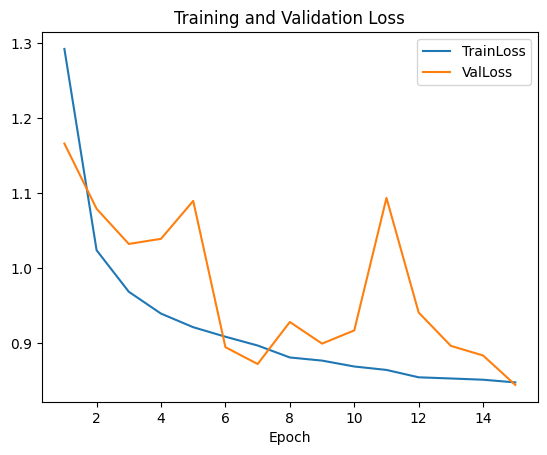

In [35]:
plot_loss(NUM_EPOCHS,TrainLoss1,ValLoss1)

In [51]:
# Model_2
model = model_2
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Train
TrainLoss2,ValLoss2 = Train_B(model,train_loader,train_loader_at_eval,test_loader,NUM_EPOCHS,criterion,optimizer,device)

-----------------------Epoch1-----------------------


100%|██████████| 1407/1407 [00:56<00:00, 24.96it/s]


Training Accuracy:  tensor(0.5822, device='cuda:0')
val  auc: 0.925  acc:0.656
test  auc: 0.928  acc:0.695
-----------------------Epoch2-----------------------


100%|██████████| 1407/1407 [00:56<00:00, 24.98it/s]


Training Accuracy:  tensor(0.6516, device='cuda:0')
val  auc: 0.934  acc:0.677
test  auc: 0.934  acc:0.705
-----------------------Epoch3-----------------------


100%|██████████| 1407/1407 [00:56<00:00, 25.07it/s]


Training Accuracy:  tensor(0.6652, device='cuda:0')
val  auc: 0.931  acc:0.678
test  auc: 0.931  acc:0.699
-----------------------Epoch4-----------------------


100%|██████████| 1407/1407 [00:57<00:00, 24.61it/s]


Training Accuracy:  tensor(0.6741, device='cuda:0')
val  auc: 0.936  acc:0.690
test  auc: 0.933  acc:0.712
-----------------------Epoch5-----------------------


100%|██████████| 1407/1407 [00:56<00:00, 25.10it/s]


Training Accuracy:  tensor(0.6827, device='cuda:0')
val  auc: 0.944  acc:0.699
test  auc: 0.941  acc:0.728
-----------------------Epoch6-----------------------


100%|██████████| 1407/1407 [00:55<00:00, 25.33it/s]


Training Accuracy:  tensor(0.6856, device='cuda:0')
val  auc: 0.943  acc:0.696
test  auc: 0.942  acc:0.724
-----------------------Epoch7-----------------------


100%|██████████| 1407/1407 [00:55<00:00, 25.15it/s]


Training Accuracy:  tensor(0.6860, device='cuda:0')
val  auc: 0.940  acc:0.702
test  auc: 0.943  acc:0.735
-----------------------Epoch8-----------------------


100%|██████████| 1407/1407 [00:56<00:00, 24.80it/s]


Training Accuracy:  tensor(0.6911, device='cuda:0')
val  auc: 0.943  acc:0.698
test  auc: 0.946  acc:0.737
-----------------------Epoch9-----------------------


100%|██████████| 1407/1407 [00:57<00:00, 24.47it/s]


Training Accuracy:  tensor(0.6920, device='cuda:0')
val  auc: 0.944  acc:0.709
test  auc: 0.944  acc:0.734
-----------------------Epoch10-----------------------


100%|██████████| 1407/1407 [00:58<00:00, 24.20it/s]


Training Accuracy:  tensor(0.6942, device='cuda:0')
val  auc: 0.944  acc:0.702
test  auc: 0.947  acc:0.722
-----------------------Epoch11-----------------------


100%|██████████| 1407/1407 [00:55<00:00, 25.21it/s]


Training Accuracy:  tensor(0.6958, device='cuda:0')
val  auc: 0.950  acc:0.720
test  auc: 0.948  acc:0.749
-----------------------Epoch12-----------------------


100%|██████████| 1407/1407 [00:56<00:00, 25.07it/s]


Training Accuracy:  tensor(0.6960, device='cuda:0')
val  auc: 0.950  acc:0.712
test  auc: 0.949  acc:0.739
-----------------------Epoch13-----------------------


100%|██████████| 1407/1407 [00:55<00:00, 25.15it/s]


Training Accuracy:  tensor(0.6989, device='cuda:0')
val  auc: 0.949  acc:0.715
test  auc: 0.949  acc:0.738
-----------------------Epoch14-----------------------


100%|██████████| 1407/1407 [00:56<00:00, 24.81it/s]


Training Accuracy:  tensor(0.6993, device='cuda:0')
val  auc: 0.949  acc:0.712
test  auc: 0.953  acc:0.733
-----------------------Epoch15-----------------------


100%|██████████| 1407/1407 [00:58<00:00, 23.94it/s]


Training Accuracy:  tensor(0.7002, device='cuda:0')
val  auc: 0.946  acc:0.716
test  auc: 0.942  acc:0.733


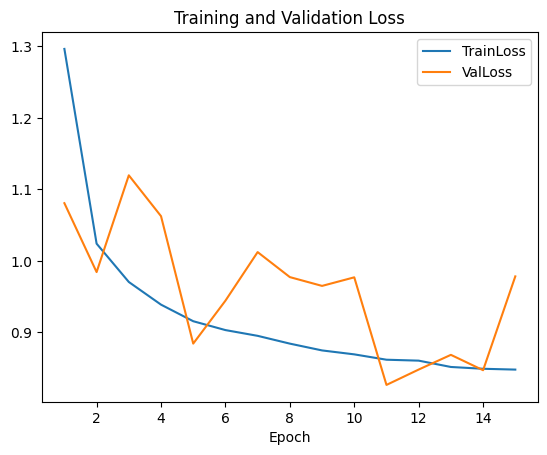

In [55]:
plot_loss(NUM_EPOCHS,TrainLoss2,ValLoss2)

In [61]:
# Model_3
model = model_3
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Train
TrainLoss3,ValLoss3 = Train_B(model,train_loader,train_loader_at_eval,test_loader,NUM_EPOCHS,criterion,optimizer,device)

-----------------------Epoch1-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.25it/s]


Training Accuracy:  tensor(0.6129, device='cuda:0')
val  auc: 0.928  acc:0.671
test  auc: 0.928  acc:0.697
-----------------------Epoch2-----------------------


100%|██████████| 1407/1407 [01:02<00:00, 22.35it/s]


Training Accuracy:  tensor(0.6703, device='cuda:0')
val  auc: 0.942  acc:0.696
test  auc: 0.951  acc:0.747
-----------------------Epoch3-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.27it/s]


Training Accuracy:  tensor(0.6833, device='cuda:0')
val  auc: 0.943  acc:0.703
test  auc: 0.948  acc:0.718
-----------------------Epoch4-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.28it/s]


Training Accuracy:  tensor(0.6901, device='cuda:0')
val  auc: 0.950  acc:0.716
test  auc: 0.951  acc:0.733
-----------------------Epoch5-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.20it/s]


Training Accuracy:  tensor(0.6960, device='cuda:0')
val  auc: 0.950  acc:0.719
test  auc: 0.958  acc:0.748
-----------------------Epoch6-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.24it/s]


Training Accuracy:  tensor(0.7000, device='cuda:0')
val  auc: 0.947  acc:0.718
test  auc: 0.958  acc:0.753
-----------------------Epoch7-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.23it/s]


Training Accuracy:  tensor(0.7044, device='cuda:0')
val  auc: 0.955  acc:0.721
test  auc: 0.958  acc:0.747
-----------------------Epoch8-----------------------


100%|██████████| 1407/1407 [01:04<00:00, 21.89it/s]


Training Accuracy:  tensor(0.7073, device='cuda:0')
val  auc: 0.957  acc:0.737
test  auc: 0.959  acc:0.747
-----------------------Epoch9-----------------------


100%|██████████| 1407/1407 [01:04<00:00, 21.85it/s]


Training Accuracy:  tensor(0.7123, device='cuda:0')
val  auc: 0.957  acc:0.732
test  auc: 0.960  acc:0.761
-----------------------Epoch10-----------------------


100%|██████████| 1407/1407 [01:04<00:00, 21.98it/s]


Training Accuracy:  tensor(0.7144, device='cuda:0')
val  auc: 0.957  acc:0.735
test  auc: 0.960  acc:0.752
-----------------------Epoch11-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.06it/s]


Training Accuracy:  tensor(0.7165, device='cuda:0')
val  auc: 0.959  acc:0.732
test  auc: 0.962  acc:0.764
-----------------------Epoch12-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.02it/s]


Training Accuracy:  tensor(0.7176, device='cuda:0')
val  auc: 0.956  acc:0.735
test  auc: 0.960  acc:0.747
-----------------------Epoch13-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.08it/s]


Training Accuracy:  tensor(0.7209, device='cuda:0')
val  auc: 0.957  acc:0.739
test  auc: 0.957  acc:0.751
-----------------------Epoch14-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.17it/s]


Training Accuracy:  tensor(0.7234, device='cuda:0')
val  auc: 0.962  acc:0.743
test  auc: 0.962  acc:0.764
-----------------------Epoch15-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.23it/s]


Training Accuracy:  tensor(0.7207, device='cuda:0')
val  auc: 0.959  acc:0.740
test  auc: 0.963  acc:0.772


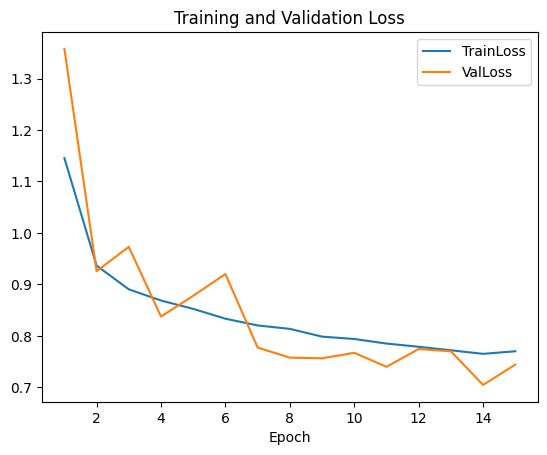

In [62]:
plot_loss(NUM_EPOCHS,TrainLoss3,ValLoss3)

In [63]:
TrainLoss4,ValLoss4 = Train_B(model,train_loader,train_loader_at_eval,test_loader,NUM_EPOCHS,criterion,optimizer,device)

-----------------------Epoch1-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.17it/s]


Training Accuracy:  tensor(0.7251, device='cuda:0')
val  auc: 0.959  acc:0.742
test  auc: 0.963  acc:0.768
-----------------------Epoch2-----------------------


100%|██████████| 1407/1407 [01:02<00:00, 22.34it/s]


Training Accuracy:  tensor(0.7254, device='cuda:0')
val  auc: 0.962  acc:0.749
test  auc: 0.965  acc:0.772
-----------------------Epoch3-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.11it/s]


Training Accuracy:  tensor(0.7269, device='cuda:0')
val  auc: 0.961  acc:0.745
test  auc: 0.962  acc:0.761
-----------------------Epoch4-----------------------


100%|██████████| 1407/1407 [01:02<00:00, 22.34it/s]


Training Accuracy:  tensor(0.7272, device='cuda:0')
val  auc: 0.959  acc:0.751
test  auc: 0.962  acc:0.756
-----------------------Epoch5-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.26it/s]


Training Accuracy:  tensor(0.7300, device='cuda:0')
val  auc: 0.964  acc:0.756
test  auc: 0.966  acc:0.770
-----------------------Epoch6-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.21it/s]


Training Accuracy:  tensor(0.7331, device='cuda:0')
val  auc: 0.963  acc:0.750
test  auc: 0.964  acc:0.761
-----------------------Epoch7-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.27it/s]


Training Accuracy:  tensor(0.7311, device='cuda:0')
val  auc: 0.963  acc:0.756
test  auc: 0.964  acc:0.776
-----------------------Epoch8-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.20it/s]


Training Accuracy:  tensor(0.7318, device='cuda:0')
val  auc: 0.963  acc:0.751
test  auc: 0.965  acc:0.780
-----------------------Epoch9-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.17it/s]


Training Accuracy:  tensor(0.7339, device='cuda:0')
val  auc: 0.962  acc:0.758
test  auc: 0.963  acc:0.759
-----------------------Epoch10-----------------------


100%|██████████| 1407/1407 [01:04<00:00, 21.97it/s]


Training Accuracy:  tensor(0.7315, device='cuda:0')
val  auc: 0.961  acc:0.744
test  auc: 0.962  acc:0.755
-----------------------Epoch11-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.16it/s]


Training Accuracy:  tensor(0.7345, device='cuda:0')
val  auc: 0.966  acc:0.764
test  auc: 0.964  acc:0.769
-----------------------Epoch12-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.03it/s]


Training Accuracy:  tensor(0.7351, device='cuda:0')
val  auc: 0.964  acc:0.754
test  auc: 0.964  acc:0.764
-----------------------Epoch13-----------------------


100%|██████████| 1407/1407 [01:03<00:00, 22.05it/s]


Training Accuracy:  tensor(0.7352, device='cuda:0')
val  auc: 0.965  acc:0.758
test  auc: 0.963  acc:0.761
-----------------------Epoch14-----------------------


100%|██████████| 1407/1407 [01:04<00:00, 21.94it/s]


Training Accuracy:  tensor(0.7384, device='cuda:0')
val  auc: 0.964  acc:0.752
test  auc: 0.964  acc:0.771
-----------------------Epoch15-----------------------


100%|██████████| 1407/1407 [01:04<00:00, 21.93it/s]


Training Accuracy:  tensor(0.7364, device='cuda:0')
val  auc: 0.963  acc:0.758
test  auc: 0.964  acc:0.763


In [72]:
print(TrainLoss3)
print(ValLoss3)
print(TrainLoss4)
print(ValLoss4)

[1.1452807756968229, 0.9364168984973016, 0.8902579002881948, 0.8685097734218128, 0.8523348282225689, 0.8331969657432295, 0.8201454584490092, 0.8134399717296364, 0.7983925006198137, 0.7937976774503427, 0.7849098286606695, 0.7786382201638049, 0.7718441542701342, 0.764920960208924, 0.7699571146385502]
[1.357485092369614, 0.9256426794513776, 0.9727641063131349, 0.8373197863815697, 0.8777476431457866, 0.9199885722178559, 0.7771119538006505, 0.75756343401921, 0.7562637925148008, 0.7669353568629856, 0.7397101580337352, 0.7742707425621668, 0.7698760249052841, 0.704533529889052, 0.7440145756029022]
[0.7583251161065268, 0.7567262207690756, 0.7520927096099488, 0.7496653079096951, 0.7450661538718182, 0.7364336994834716, 0.739673569300705, 0.735213953718363, 0.7309595167891049, 0.7342165234924295, 0.7299037224956667, 0.727423062308426, 0.7257762603414084, 0.721300708798542, 0.7207650802367617]
[0.737027889983669, 0.7093061539018229, 0.7251301170534388, 0.7475661914439719, 0.681283837101262, 0.68559

In [ ]:
# 1) CNN from scratch
model = model_0

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define the loss function
criterion = nn.CrossEntropyLoss()

-----------------------Epoch1-----------------------


100%|██████████| 2813/2813 [00:57<00:00, 49.28it/s]


val  auc: 0.981  acc:0.809
test  auc: 0.973  acc:0.805
-----------------------Epoch2-----------------------


100%|██████████| 2813/2813 [00:55<00:00, 50.68it/s]


val  auc: 0.988  acc:0.861
test  auc: 0.963  acc:0.787
-----------------------Epoch3-----------------------


100%|██████████| 2813/2813 [00:57<00:00, 49.29it/s]


val  auc: 0.994  acc:0.911
test  auc: 0.976  acc:0.828
-----------------------Epoch4-----------------------


100%|██████████| 2813/2813 [00:55<00:00, 50.54it/s]


val  auc: 0.993  acc:0.900
test  auc: 0.958  acc:0.712
-----------------------Epoch5-----------------------


100%|██████████| 2813/2813 [00:54<00:00, 51.67it/s]


val  auc: 0.997  acc:0.932
test  auc: 0.964  acc:0.812
-----------------------Epoch6-----------------------


100%|██████████| 2813/2813 [00:54<00:00, 51.86it/s]


val  auc: 0.995  acc:0.917
test  auc: 0.958  acc:0.753
-----------------------Epoch7-----------------------


100%|██████████| 2813/2813 [00:54<00:00, 51.97it/s]


val  auc: 0.995  acc:0.914
test  auc: 0.961  acc:0.719
-----------------------Epoch8-----------------------


100%|██████████| 2813/2813 [00:53<00:00, 52.89it/s]


val  auc: 0.998  acc:0.947
test  auc: 0.969  acc:0.824
-----------------------Epoch9-----------------------


100%|██████████| 2813/2813 [00:56<00:00, 49.85it/s]


val  auc: 0.997  acc:0.945
test  auc: 0.972  acc:0.834
-----------------------Epoch10-----------------------


100%|██████████| 2813/2813 [00:54<00:00, 51.69it/s]


val  auc: 0.998  acc:0.953
test  auc: 0.965  acc:0.809


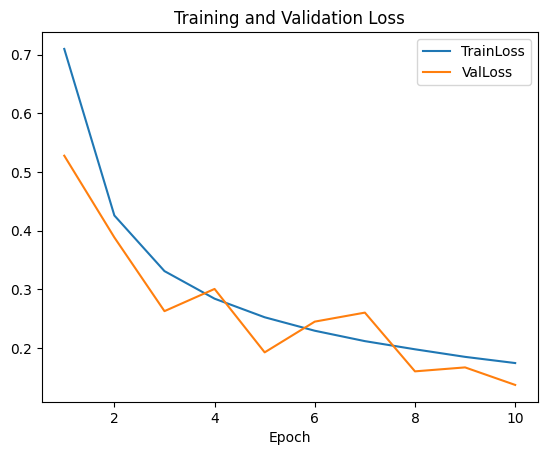

In [ ]:
plot_loss(NUM_EPOCHS,TrainLoss,ValLoss)

In [ ]:
# 1) Fine-tune ResNet50
model = model_1

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
TrainLoss,ValLoss = Train_B(model,train_loader,train_loader_at_eval,test_loader,NUM_EPOCHS,criterion,optimizer,device)

-----------------------Epoch1-----------------------


100%|██████████| 1407/1407 [01:35<00:00, 14.74it/s]


Training Accuracy:  tensor(0.8375, device='cuda:0')
val  auc: 0.995  acc:0.912
test  auc: 0.973  acc:0.820
-----------------------Epoch2-----------------------


100%|██████████| 1407/1407 [01:38<00:00, 14.35it/s]


Training Accuracy:  tensor(0.9088, device='cuda:0')
val  auc: 0.996  acc:0.929
test  auc: 0.977  acc:0.860
-----------------------Epoch3-----------------------


100%|██████████| 1407/1407 [01:36<00:00, 14.58it/s]


Training Accuracy:  tensor(0.9247, device='cuda:0')
val  auc: 0.997  acc:0.938
test  auc: 0.974  acc:0.825
-----------------------Epoch4-----------------------


100%|██████████| 1407/1407 [01:35<00:00, 14.69it/s]


Training Accuracy:  tensor(0.9329, device='cuda:0')
val  auc: 0.997  acc:0.944
test  auc: 0.979  acc:0.835
-----------------------Epoch5-----------------------


100%|██████████| 1407/1407 [01:35<00:00, 14.69it/s]


Training Accuracy:  tensor(0.9408, device='cuda:0')
val  auc: 0.998  acc:0.954
test  auc: 0.975  acc:0.850
-----------------------Epoch6-----------------------


100%|██████████| 1407/1407 [01:36<00:00, 14.55it/s]


Training Accuracy:  tensor(0.9465, device='cuda:0')
val  auc: 0.998  acc:0.949
test  auc: 0.981  acc:0.842
-----------------------Epoch7-----------------------


100%|██████████| 1407/1407 [01:36<00:00, 14.55it/s]


Training Accuracy:  tensor(0.9491, device='cuda:0')
val  auc: 0.998  acc:0.957
test  auc: 0.977  acc:0.820
-----------------------Epoch8-----------------------


100%|██████████| 1407/1407 [01:36<00:00, 14.64it/s]


Training Accuracy:  tensor(0.9551, device='cuda:0')
val  auc: 0.998  acc:0.957
test  auc: 0.974  acc:0.824
-----------------------Epoch9-----------------------


100%|██████████| 1407/1407 [01:36<00:00, 14.55it/s]


Training Accuracy:  tensor(0.9535, device='cuda:0')
val  auc: 0.985  acc:0.942
test  auc: 0.977  acc:0.842
-----------------------Epoch10-----------------------


100%|██████████| 1407/1407 [01:36<00:00, 14.59it/s]


Training Accuracy:  tensor(0.9606, device='cuda:0')
val  auc: 0.979  acc:0.940
test  auc: 0.960  acc:0.806


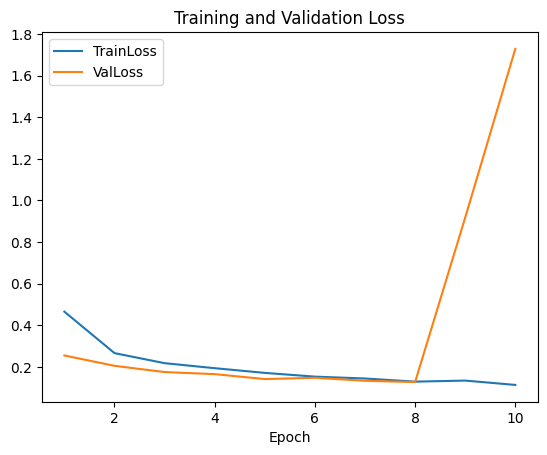

In [ ]:
plot_loss(NUM_EPOCHS,TrainLoss,ValLoss)

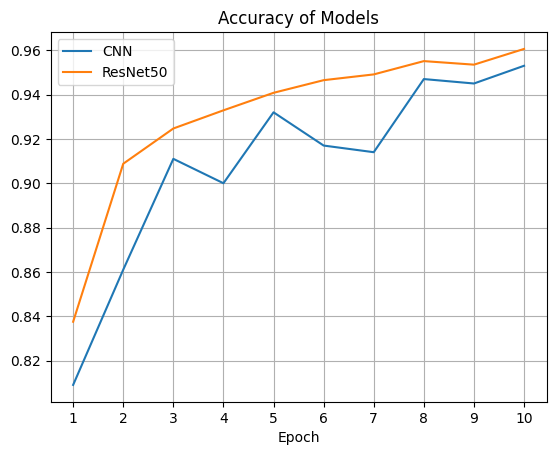

In [ ]:
ACC_cnn = [0.809,0.861,0.911,0.900,0.932,0.917,0.914,0.947,0.945,0.953]
ACC_res = [0.8375,0.9088,0.9247,0.9329,0.9408,0.9465,0.9491,0.9551,0.9535,0.9606]
plt.plot(range(1,NUM_EPOCHS+1),ACC_cnn)
plt.plot(range(1,NUM_EPOCHS+1),ACC_res)
plt.legend(['CNN','ResNet50'])
plt.title("Accuracy of Models")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.grid()
plt.show()

In [32]:
len(val)

31

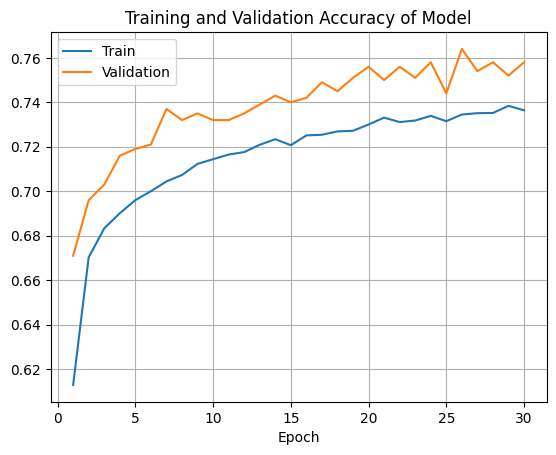

In [35]:
# ACC
import matplotlib.pyplot as plt
train=[0.6129,0.6703,0.6833,0.6901,0.6960,0.7,0.7044,0.7073,0.7123,0.7144,0.7165,0.7176,0.7209,0.7234,0.7207,0.7251,0.7254,0.7269,0.7272,0.73,0.7331,0.7311,0.7318,0.7339,0.7315,0.7345,0.7351,0.7352,0.7384,0.7364]
val=[0.671,0.696,0.703,0.716,0.719,0.721,0.737,0.732,0.735,0.732,0.732,0.735,0.739,0.743,0.74,0.742,0.749,0.745,0.751,0.756,0.75,0.756,0.751,0.758,0.744,0.764,0.754,0.758,0.752,0.758]
plt.plot(range(1,31),train)
plt.plot(range(1,31),val)

plt.legend(['Train','Validation'])
plt.title("Training and Validation Accuracy of Model")
plt.xlabel("Epoch")
#plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28])
plt.grid()
plt.show()